In [1]:
import pandas as pd
from helpers import *
import warnings
import seaborn as sns
import datetime as dt

In [2]:
warnings.filterwarnings('ignore')
df_ = pd.read_excel(r"C:\Users\oe\Desktop\DSMLBC4\datasets\online_retail_II.xlsx", sheet_name="Year 2010-2011")
df = df_.copy()
df.head()

,Invoice,StockCode,Description,Quantity,InvoiceDate,Price,Customer ID,Country
0,536365,85123A,WHITE HANGING HEART T-LIGHT HOLDER,6,2010-12-01 08:26:00,2.55,17850.0,United Kingdom
1,536365,71053,WHITE METAL LANTERN,6,2010-12-01 08:26:00,3.39,17850.0,United Kingdom
2,536365,84406B,CREAM CUPID HEARTS COAT HANGER,8,2010-12-01 08:26:00,2.75,17850.0,United Kingdom
3,536365,84029G,KNITTED UNION FLAG HOT WATER BOTTLE,6,2010-12-01 08:26:00,3.39,17850.0,United Kingdom
4,536365,84029E,RED WOOLLY HOTTIE WHITE HEART.,6,2010-12-01 08:26:00,3.39,17850.0,United Kingdom


In [3]:
df = df_.copy()

In [4]:
# Fatura tarihini datetime formatına çevirme
df['InvoiceDate'] = pd.to_datetime(df['InvoiceDate']).dt.date

# NA Değerleri veri setinden çıkarma
df.dropna(inplace=True)

# C iadeleri ifade ediyor, veri setinden çıkaralım.
df = df[~df["Invoice"].str.contains("C", na=False)]

# Adet miktarının 0'dan büyük olması gerek.
df = df[df["Quantity"] > 0]

# Aykırı değerlere baskılama işlemi (0.99-0.01)
replace_with_thresholds(df, "Quantity")
replace_with_thresholds(df, "Price")

# Toplam Fiyat için bir değişken oluşturma
df["TotalPrice"] = df["Quantity"] * df["Price"]


In [5]:
cltv_cols = df[['Customer ID', 'InvoiceDate', 'TotalPrice']]
cltv_cols.head()

,Customer ID,InvoiceDate,TotalPrice
0,17850.0,2010-12-01,15.30
1,17850.0,2010-12-01,20.34
2,17850.0,2010-12-01,22.00
3,17850.0,2010-12-01,20.34
4,17850.0,2010-12-01,20.34


In [6]:
# Tekil müşteri sayısı
df['Customer ID'].nunique()

4339

<ul>
<li><p><strong>Frequency</strong>: Müşterinin yaptığı tekrar satın alma sayısını temsil eder. </p>
<p>RFM de bunu satın alma sayısı olarak almıştık CLTV hesabında ise müşterinin toplam satın alma sayısından bir eksik olacak şekilde alacağız.</p>
<p>	<code>- Invoice.nunique() - 1</code></p>
</li>

</ul>
<ul>
<li><p><strong>T</strong>, seçilen zaman birimlerinde (veri setimizde günlük olarak) müşterinin yaşını temsil eder. </p>
<p>Müşterinin ilk satın alımı ile incelenen dönemin sonu arasındaki süreye eşittir.</p>
<p>	<code>- Analiz Tarihi - İlk satın alma tarihi</code></p>
</li>

</ul>
<ul>
<li><p><strong>Recency</strong>, müşterinin en son alışverişlerini yaptığı yaşını temsil eder. </p>
<p>Müşterinin ilk satın alımı ile son satın alımı arasındaki süreye eşittir. (Dolayısıyla, yalnızca 1 satın alma yapmışlarsa, yenilik 0'dır.)</p>
<p>	<code>- Son satın alım tarihi - İlk satın alım tarihi </code></p>
</li>

</ul>

<p>Bu çalışma için pythondaki lifetimes kütüphanesini kullanacağız.</p>
<h1> Data Explore </h1>

In [35]:
from lifetimes.plotting import *
from lifetimes.utils import *
df["InvoiceDate"].max()

datetime.date(2011, 12, 9)

In [9]:
data = summary_data_from_transaction_data(df, 'Customer ID', 'InvoiceDate', 'TotalPrice', 
                                          observation_period_end=df["InvoiceDate"].max(), freq="D")
data.head()
# Dikkat doğru tarih formatı: '2011-12-9'
# Bu şekilde yanlış alıyor: '2011,12,9'

,frequency,recency,T,monetary_value
Customer ID,,,,
12346.0,0.0,0.0,325.0,0.000000
12347.0,6.0,365.0,367.0,599.701667
12348.0,3.0,283.0,358.0,298.540000
12349.0,0.0,0.0,18.0,0.000000
12350.0,0.0,0.0,310.0,0.000000


In [10]:
df[df["Customer ID"]==12346.0].groupby("Invoice").sum()

,Quantity,Price,Customer ID,TotalPrice
Invoice,,,,
541431,298.5,1.04,12346.0,310.44


Kullanıcı 12346.0 sadece 1 alışveriş yapmış (tekrar yok) bu sebeple frequency ve recency değerleri 0

In [11]:
df[df["Customer ID"]==12348.0].groupby("Invoice").sum()

,Quantity,Price,Customer ID,TotalPrice
Invoice,,,,
539318,1254.0,46.66,209916.0,875.16
541998,601.0,39.07,74088.0,224.50
548955,269.0,41.66,61740.0,364.06
568172,217.0,39.56,37044.0,307.06


Kullanıcı <code>12348</code> ise 4 farklı günde işlemi var, ilk işlemini dahil etmeyip monetary hesabı yapılıyor. 

In [12]:
(227.44 + 367.00 + 310.00) / 3

301.48

count    4339.000000
mean        2.864024
std         5.952745
min         0.000000
25%         0.000000
50%         1.000000
75%         3.000000
max       131.000000
Name: frequency, dtype: float64

 Sadece 1 kez alışveriş yapanlar % 0.357


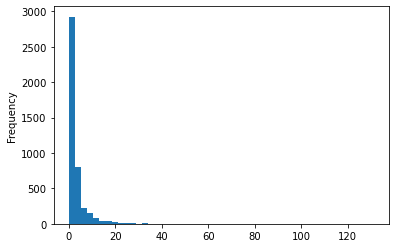

In [13]:
# Veri setimizdeki tüm kullanıcıların neredeyse %35i 1 kez alışveriş yapmış.
data['frequency'].plot(kind='hist', bins=50)
print(data['frequency'].describe())
print("\n","Sadece 1 kez alışveriş yapanlar %",round(sum(data['frequency'] == 0)/float(len(data)),3))

## BG/NBD Modelini Kullanarak Frequency/Recency Analizi

In [14]:
from lifetimes import BetaGeoFitter

bgf = BetaGeoFitter(penalizer_coef=0.0)
bgf.fit(data['frequency'], data['recency'], data['T'])
print(bgf)

<lifetimes.BetaGeoFitter: fitted with 4339 subjects, a: 0.00, alpha: 68.89, b: 6.75, r: 0.83>


<p>Küçük verisetleri için, parametreler inanılmaz derecede büyük olabilir, bu nedenle olasılığa bir l2 cezası ekleyerek, bu parametrelerin ne kadar büyük olabileceğini kontrol edebiliriz. </p>
<p>Bunu modeli fit ederken penalizer_coef değeri girerek yapıyoruz. </p>
<p>Tipik uygulamalarda, 0,001 ila 0,1 arasındaki cezalandırıcılar etkilidir.</p>

In [15]:
bgf.summary

,coef,se(coef),lower 95% bound,upper 95% bound
r,0.826433,0.026780,0.773944,0.878922
alpha,68.890678,2.611055,63.773011,74.008345
a,0.003443,0.010347,-0.016837,0.023722
b,6.749363,22.412933,-37.179985,50.678711


<p>Consider: a customer has made purchase every day for four weeks straight, and then we haven’t heard from him in months. What are the chances he is still “alive”? Pretty small, right? On the other hand, a customer who historically made purchase once a quarter, and again last quarter, is likely still alive. We can visualize this relationship using the frequency/recency matrix, which computes the expected number of transactions an artificial customer is to make in the next time period, given his recency (age at last purchase) and frequency (the number of repeat transactions he has made).</p>

<p>Şöyle düşünelim: </p>
<p>Ayşe Hanım 4 hafta boyunca her gün bizden alışveriş  yapmış olsun ve kendisinden bu ay hiçbir haber alamıyoruz.</p>
<p>Ayşe Hanımın <strong>bizim için</strong> ‘alive’ yani <strong>yaşıyor</strong> olmasının ihtimali nedir? Oldukça düşüktür değil mi?</p>
<p>Diğer yandan Mehmet Bey; Bizimle her üç ayda bir alışveriş yapıyor ve geçen çeyreklikte de alışverişini yapmış. Mehmet Bey bizim için hala yaşıyor diyebiliriz.</p>
<p>Bir müşterinin bir sonraki zaman diliminde yapması beklenen işlem sayısını: Frequency / Recency matrisini kullanarak görselleştirebiliriz.</p>
<p><strong>Frequency</strong> ( Tekrar yaptığı alışveriş sayısı ) / <strong>Recency</strong> ( son alışveriş tarihi - ilk alışveriş tarihi) </p>

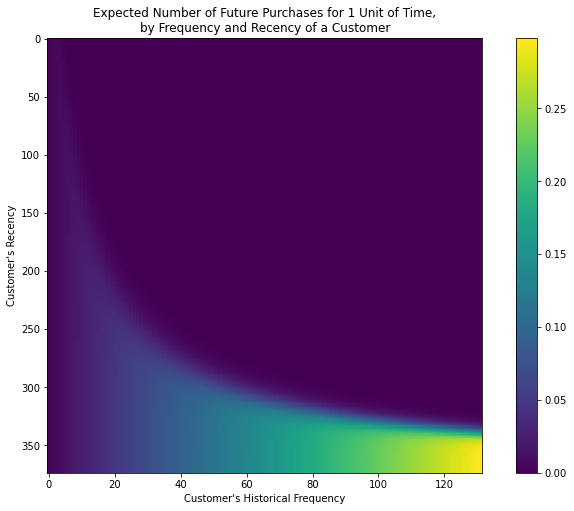

In [16]:
from lifetimes.plotting import plot_frequency_recency_matrix
import matplotlib.pyplot as plt
# sns.set_style("whitegrid")

fig = plt.figure(figsize=(12,8));
plot_frequency_recency_matrix(bgf);

<p>Bir müşteri 120 satın alma işlemi gerçekleştirdiyse ve en son satın alma işlemi yaklaşık 350 <strong>günlükken</strong> gerçekleştiyse o zaman en iyi müşterimizdir. </p>
<p>(Recency: İlk işlemi ile son işlemi arasındaki süre 350 gün ise)  Bu durumu sağ alt tarafta gözlemleyebiliriz.</p>
<p>Çok fazla satın alma işlemi gerçekleştirmiş ve bu işlemleri de yakın zamanda gerçekleştirmiş müşteriler gelecekte en iyi müşteriler olacaktır.</p>
<p>Ayrıca 40 - 300 aralıkların farklı bir kullanıcı tipini gözlemleyebiliriz. Bu müşterilerimizi son zamanlarda görmediğimiz için tekrar satın alma işlemini gerçekleştirebilirler. Fakat  bu müşterilerin bizi terk ettiklerini mi yoksa satın alma periyotlarının içerisinde mi olduklarını tam olarak kestiremiyoruz.</p>

<p>Müşterilerin hala <strong>alive</strong> (hayatta olma) olasılığına bakmak istersek:</p>

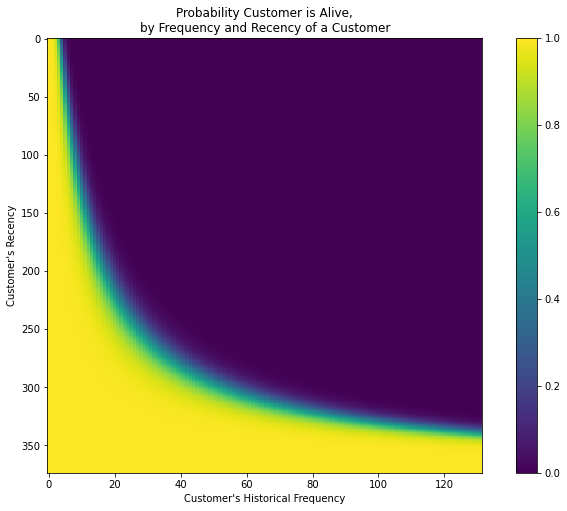

In [17]:
from lifetimes.plotting import plot_probability_alive_matrix
fig = plt.figure(figsize=(12,8))
plot_probability_alive_matrix(bgf);

<p>Yakın zamanda satın alan müşteriler neredeyse kesinlikle &quot;<strong>canlıdır</strong>&quot;.</p>
<p>Çok sık alışveriş yapan fakat son zamanlarda uğramayan müşteriler churn olmaya doğru giden kullanıcılar. Bu kullanıcılar geçmişte ne kadar fazla alışveriş yaptılarsa o kadar churn olasılıkları artıyor. (Sağ üst tarafta gözlemlenebilir)</p>

In [18]:
# Müşteri alive olasılıklarını hesaplama
data['probability_alive'] = bgf.conditional_probability_alive(data['frequency'], data['recency'], data['T'])
data.head(10)

,frequency,recency,T,monetary_value,probability_alive
Customer ID,,,,,
12346.0,0.0,0.0,325.0,0.000000,1.000000
12347.0,6.0,365.0,367.0,599.701667,0.999698
12348.0,3.0,283.0,358.0,298.540000,0.999177
12349.0,0.0,0.0,18.0,0.000000,1.000000
12350.0,0.0,0.0,310.0,0.000000,1.000000
12352.0,6.0,260.0,296.0,243.306667,0.999405
12353.0,0.0,0.0,204.0,0.000000,1.000000
12354.0,0.0,0.0,232.0,0.000000,1.000000
12355.0,0.0,0.0,214.0,0.000000,1.000000


<p>Müşterileri en çok satın alma olasılıklarına göre çoktan aza doğru sıralayalım.</p>
<p>Kullanacağımız model, müşterilerin geçmiş alışveriş alışkanlıklarını kullanarak gelecek dönemde beklenen satın alma işlemlerini tahmin etmeye yarıyor.</p>

In [19]:
t = 30
data['predicted_purchases'] = bgf.conditional_expected_number_of_purchases_up_to_time(t, data['frequency'], data['recency'], data['T'])
data.sort_values(by='predicted_purchases', ascending=False).head()

,frequency,recency,T,monetary_value,probability_alive,predicted_purchases
Customer ID,,,,,,
14911.0,131.0,372.0,373.0,1057.185420,0.999966,8.948418
12748.0,113.0,373.0,373.0,286.508496,0.999971,7.726616
17841.0,111.0,372.0,373.0,363.957477,0.999962,7.590787
15311.0,89.0,373.0,373.0,677.729438,0.999964,6.097442
14606.0,88.0,372.0,373.0,135.279659,0.999955,6.029510


<p>Yukarıda listelenenler, modelin ertesi gün satın alım yapmalarını beklediği ilk 5 müşterimizdir.</p>
<p><strong>predicted_purchases</strong>, Beklenen Satın Alma sayısını temsil ederken diğer üç sütun, mevcut RFM metriklerini temsil eder. </p>
<p><strong>BG/NBD</strong> modeli, bu kişilerin şu anki en iyi müşterilerimiz oldukları için yakın gelecekte daha fazla alışveriş yapacaklarına inanmaktadır.</p>

# Assessing model fit

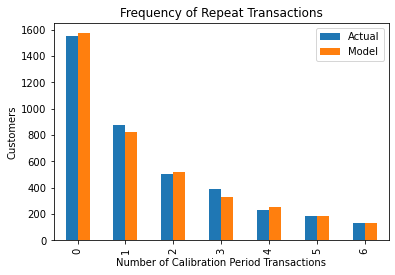

In [20]:
from lifetimes.plotting import plot_period_transactions
plot_period_transactions(bgf);

<p>Modeli kurduk fakat ne kadar iyi?</p>
<p>Gördüğümüz gibi model hiç kötü değil, bu yüzden analizimize devam edebiliriz.</p>

<p> Şimdi de tıpkı makine öğrenmesindeki cross-validation gibi modelimizin görmediği veri üzerindeki durumunu gözlemleyelim. </p>

In [21]:
from lifetimes.utils import calibration_and_holdout_data
summary_cal_holdout = calibration_and_holdout_data(df, 'Customer ID', 'InvoiceDate',
                                        calibration_period_end='2011-06-09',   #train setinin aralığı
                                        observation_period_end='2011-12-9' )   #bitiş tarihi
print(summary_cal_holdout.head())

             frequency_cal  recency_cal  T_cal  frequency_holdout  \
Customer ID                                                         
12346.0                0.0          0.0  142.0                0.0   
12347.0                3.0        184.0  184.0                3.0   
12348.0                2.0        110.0  175.0                1.0   
12350.0                0.0          0.0  127.0                0.0   
12352.0                3.0         34.0  113.0                3.0   

             duration_holdout  
Customer ID                    
12346.0                 183.0  
12347.0                 183.0  
12348.0                 183.0  
12350.0                 183.0  
12352.0                 183.0  


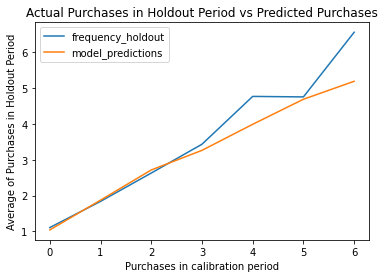

In [22]:
from lifetimes.plotting import plot_calibration_purchases_vs_holdout_purchases

bgf.fit(summary_cal_holdout['frequency_cal'], summary_cal_holdout['recency_cal'], 
        summary_cal_holdout['T_cal'])
plot_calibration_purchases_vs_holdout_purchases(bgf, summary_cal_holdout);

Yukarıdaki grafikte train ve test seti olarak ayırdığımız verileri görebiliriz. 

- Train döneminin bitişi "2011-06-09" iken
- Test döneminin bitişi "2011-12-9" tarihidir. 

Grafik train periyodundaki tüm müşterileri tekrar alım sayısına göre (x ekseni) gruplar ve 
ardından bekleme süresindeki (y ekseni) tekrar alımlarının ortalamasını alır. 

Mavi ve turuncu çizgi sırasıyla, train ve test setini belirtir. Gördüğümüz gibi modelimiz müşteri davranışını çok doğru bir şekilde tahmin edebiliyor. 

Fakat 4. ve 5. satın alımlar sonrasında eksik tahminler yapıyor.

# Müşteri Bazında Tahmin
Müşteri geçmişine dayanarak, artık bir bireyin gelecekteki satın alımlarını da tahmin etmemiz mümkün.

In [23]:
t = 10
individual = data.loc[15498.0]
bgf.predict(t, individual['frequency'], individual['recency'], individual['T'])

0.3919358056043777

Modelimiz, müşteri 15498'nin gelecekteki işleminin 10 gün içinde 0.391 olduğunu tahmin ediyor.

# Müşteri olasılık geçmişleri

Bir müşteri işlem geçmişi göz önüne alındığında, eğitimli modelimize göre onların geçmişte hayatta olma olasılıklarını hesaplayabiliriz. 

Örneğin, en iyi müşterimizin işlem geçmişine bakmak ve hayatta olma olasılığını görmek istersek;

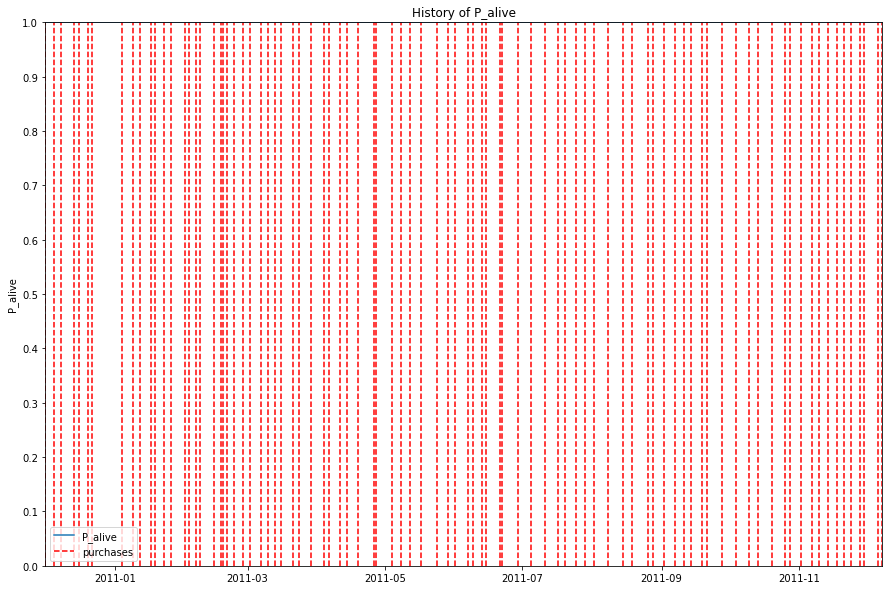

In [24]:
from lifetimes.plotting import plot_history_alive
fig = plt.figure(figsize=(15,10))
id = 14606.0
days_since_birth = 200
sp_trans = df.loc[df['Customer ID'] == id]
plot_history_alive(bgf, days_since_birth, sp_trans, 'InvoiceDate');

En iyi müşterimizi inceleyecek olursak kendisi kesinlikle canlı yani aktif olarak alışverişlerini sürdürüyor. 

Fakat 2011in ikinci yarısında birkaç ara verdiği aralık mevcut.

# GammaGamma Modelinin Kurulması
Beklenen ortalama kârlılık değerlerini gösterir. Burada GammaGamma modelini kurabilmemiz için en az 1 kere alışverişini tekrar ettiren kullanıcıları seçmemiz gerekiyor.

Bu sebeple tekil müşteri sayımız 2790'a düşmekte.

In [25]:
returning_customers_summary = data[data['frequency']>0]
print(returning_customers_summary.head())
print(len(returning_customers_summary))

             frequency  recency      T  monetary_value  probability_alive  \
Customer ID                                                                 
12347.0            6.0    365.0  367.0      599.701667           0.999698   
12348.0            3.0    283.0  358.0      298.540000           0.999177   
12352.0            6.0    260.0  296.0      243.306667           0.999405   
12356.0            2.0    303.0  325.0      269.905000           0.999478   
12358.0            1.0    149.0  150.0      671.440000           0.999486   

             predicted_purchases  
Customer ID                       
12347.0                 0.469651  
12348.0                 0.268668  
12352.0                 0.560863  
12356.0                 0.215146  
12358.0                 0.250171  
2790


In [26]:
from lifetimes import GammaGammaFitter
ggf = GammaGammaFitter(penalizer_coef = 0)
ggf.fit(returning_customers_summary['frequency'],
        returning_customers_summary['monetary_value'])
print(ggf)

<lifetimes.GammaGammaFitter: fitted with 2790 subjects, p: 2.04, q: 3.70, v: 534.86>


In [27]:
# Bize en çok kâr getireceğini tahmin ettiğimiz 10 müşterimiz
print(ggf.conditional_expected_average_profit(
        data['frequency'],
        data['monetary_value']).sort_values(ascending=False).head(10))

Customer ID
18102.0    8254.855139
12415.0    6975.004437
14646.0    5882.205626
17450.0    4781.637302
16684.0    3777.284494
14088.0    3526.085776
17511.0    3165.136879
14096.0    3133.348112
12753.0    2903.642487
13081.0    2841.556294
dtype: float64


# BG-NBD ve GG modeli ile CLTV'nin hesaplanması.

In [28]:
cltv = ggf.customer_lifetime_value(bgf,
                                   data['frequency'],
                                   data['recency'],
                                   data['T'],
                                   data['monetary_value'],
                                   time=3,  # 3 aylık
                                   freq="W",  # T'nin frekans bilgisi.
                                   discount_rate=0.01)

In [29]:
cltv = cltv.reset_index()
cltv.sort_values(by="clv", ascending=False).head(10)

,Customer ID,clv
1690,14646.0,8100.719883
4202,18102.0,6342.024679
1290,14096.0,4133.871765
1880,14911.0,4073.843336
3729,17450.0,3816.337753
55,12415.0,3523.931657
1334,14156.0,3387.052777
3772,17511.0,2584.418834
997,13694.0,1839.449317
3177,16684.0,1812.760173


In [30]:
cltv = data.merge(cltv, on="Customer ID", how='left')

In [31]:
cltv.head(10)

,Customer ID,frequency,recency,T,monetary_value,probability_alive,predicted_purchases,clv
0,12346.0,0.0,0.0,325.0,0.000000,1.000000,0.062942,9.888645
1,12347.0,6.0,365.0,367.0,599.701667,0.999698,0.469651,113.489778
2,12348.0,3.0,283.0,358.0,298.540000,0.999177,0.268668,37.705592
3,12349.0,0.0,0.0,18.0,0.000000,1.000000,0.285291,48.240150
4,12350.0,0.0,0.0,310.0,0.000000,1.000000,0.065433,10.288286
5,12352.0,6.0,260.0,296.0,243.306667,0.999405,0.560863,65.660722
6,12353.0,0.0,0.0,204.0,0.000000,1.000000,0.090849,14.401153
7,12354.0,0.0,0.0,232.0,0.000000,1.000000,0.082395,13.025674
8,12355.0,0.0,0.0,214.0,0.000000,1.000000,0.087637,13.877775
9,12356.0,2.0,303.0,325.0,269.905000,0.999478,0.215146,29.300763


In [32]:
from sklearn.preprocessing import MinMaxScaler
scaler = MinMaxScaler(feature_range=(0, 1))
scaler.fit(cltv[["clv"]])
cltv["scaled_clv"] = scaler.transform(cltv[["clv"]])

cltv["segment"] = pd.qcut(cltv["scaled_clv"], 5, labels=["E","D", "C", "B", "A"])


In [33]:
cltv.sort_values(by="scaled_clv", ascending=False).head(10)

,Customer ID,frequency,recency,T,monetary_value,probability_alive,predicted_purchases,clv,scaled_clv,segment
1690,14646.0,44.0,353.0,354.0,6047.558295,0.999923,3.179414,8100.719883,1.000000,A
4202,18102.0,25.0,367.0,367.0,8671.891800,0.999888,1.777120,6342.024679,0.782660,A
1290,14096.0,16.0,97.0,101.0,3359.947500,0.999764,2.969903,4133.871765,0.509777,A
1880,14911.0,131.0,372.0,373.0,1057.185420,0.999966,8.948418,4073.843336,0.502359,A
3729,17450.0,26.0,359.0,367.0,5005.259808,0.999822,1.845807,3816.337753,0.470536,A
55,12415.0,15.0,313.0,337.0,7556.773333,0.999565,1.169134,3523.931657,0.434401,A
1334,14156.0,42.0,362.0,371.0,2751.950238,0.999825,2.919897,3387.052777,0.417485,A
3772,17511.0,27.0,371.0,373.0,3300.981296,0.999881,1.888729,2584.418834,0.318296,A
997,13694.0,34.0,370.0,373.0,1853.390147,0.999890,2.363872,1839.449317,0.226232,A
3177,16684.0,15.0,354.0,358.0,4075.991667,0.999807,1.111896,1812.760173,0.222934,A


In [34]:
pd.set_option('display.max_columns', None)
cltv.groupby("segment").agg({"count","mean","sum"})

Customer ID                           frequency                    \
              count          mean         sum     count      mean     sum   
segment                                                                     
E               868  15344.001152  13318593.0       868  0.178571   155.0   
D               868  15334.604839  13310437.0       868  0.964286   837.0   
C               874  15421.292906  13478210.0       874  1.427918  1248.0   
B               861  15291.284553  13165796.0       861  2.871080  2472.0   
A               868  15107.592166  13113390.0       868  8.888249  7715.0   

        recency                           T                        \
          count        mean       sum count        mean       sum   
segment                                                             
E           868   29.491935   25599.0   868  277.540323  240905.0   
D           868  112.163594   97358.0   868  213.417051  185246.0   
C           874  115.549199  100990.0   874  169.475973  148122.0   
B           861  159.411150  137253.0   861  194.031359  167061.0   
A           868  237.427419  206087.0   868  259.586406  225321.0   

        monetary_value                            probability_alive            \
                 count        mean            sum             count      mean   
segment                                                                         
E                  868   21.561593   18715.462333               868  0.999585   
D                  868  139.116442  120753.071524               868  0.998332   
C                  874  175.273801  153189.302461               874  0.999010   
B                  861  301.015824  259174.624880               861  0.999074   
A                  868  635.906363  551966.722986               868  0.999026   

                    predicted_purchases                         clv  \
                sum               count      mean         sum count   
segment                                                               
E        867.639946                 868  0.087557   75.999565   868   
D        866.552309                 868  0.183798  159.536617   868   
C        873.134452                 874  0.270119  236.083756   874   
B        860.202555                 861  0.407898  351.199801   861   
A        867.154850                 868  0.847159  735.334338   868   

                                   scaled_clv                       
               mean            sum      count      mean        sum  
segment                                                             
E         12.825138   11132.219604        868  0.000498   0.432263  
D         24.674424   21417.400158        868  0.001962   1.703306  
C         37.821266   33055.786655        874  0.003587   3.135056  
B         58.796967   50624.188944        861  0.006179   5.320289  
A        220.492773  191387.726658        868  0.026162  22.708238